<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM

In [2]:
! wget -q https://xgass.icrar.org/assets/data/xGASS_representative_sample.ascii

In [3]:
# Loading the xGASS dataset with specific columns selected
xGASStb= np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[8,9,10,16,18,1,23,24,26,27,31,32], unpack= 'true')
# Loading the specfic columns with flags as separate arrays
HIsrc, HI_FLAG = np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[26,27], unpack= 'true')
# Removing data with an index that falls into the conditions HI_FLAG >1 or HI_FLAG <90
xGASSRd = np.delete(xGASStb, np.where((HI_FLAG >1) & (HI_FLAG < 90)), axis = 1)
xGASST = xGASSRd.T

# Assigning the 1d arrays to the correct column of data
zSDSS = xGASST[:,0]
Dlum = xGASST[:,1]
lgMstar = xGASST[:,2]
petro90r = xGASST[:,3]
lgmust = xGASST[:,4]
lgSFR_tot_median = xGASST[:,5]
SFR_best = xGASST[:,6]
SFRerr_best = xGASST[:,7]
HIsrc = xGASST[:,8]
HI_FLAG = xGASST[:,9]
lgMHI = xGASST[:,10]
lgGF = xGASST[:,11]

In [4]:
# Testing to ensure the correct arrays are filled with the correct values
print(zSDSS)
print(Dlum)
print(lgMstar)
print(petro90r)
print(lgmust)
print(lgSFR_tot_median)
print(SFR_best)
print(SFRerr_best)
print(HIsrc)
print(HI_FLAG)
print(lgMHI)
print(lgGF)

[0.03618 0.03573 0.04201 ... 0.04656 0.02704 0.03797]
[159.2 157.2 185.7 ... 206.5 118.2 167.3]
[10.709 10.539 10.625 ... 10.946 10.334 10.25 ]
[10.51  9.96  7.01 ... 13.09  6.66 14.09]
[9.18 9.05 9.32 ... 9.08 9.37 8.12]
[101866. 101874. 101876. ... 332851. 332201. 332883.]
[0.82985944 0.03869768 0.0620131  ... 2.902701   0.03280856 0.93741816]
[0.         0.07982571 0.15414698 ... 0.42542186 0.         0.28900966]
[3. 4. 3. ... 4. 4. 3.]
[ 1. 99.  1. ... 99. 99.  1.]
[9.603 8.74  9.244 ... 9.183 8.664 9.517]
[-1.106 -1.799 -1.381 ... -1.763 -1.67  -0.733]


In [5]:
# Finding all the rows in the xGASS data with HIsrc < 4, if HIsrc = 4, no detection of HI
# Subtracting no HI detection
# All HI-detected galaxy properties below
HIndet = np.where(HIsrc >= 4)[0]

zSDSS1 = np.delete(zSDSS, (HIndet))
Dlum1 = np.delete(Dlum, (HIndet))
lgMstar1 = np.delete(lgMstar, (HIndet))
petro90r1 = np.delete(petro90r, (HIndet))
lgmust1 = np.delete(lgmust, (HIndet))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (HIndet))
SFR_best1 = np.delete(SFR_best, (HIndet))
lgSFR1 = np.log10(SFR_best1)
SFRerr_best1 = np.delete(SFRerr_best, (HIndet))
HIsrc1 = np.delete(HIsrc, (HIndet))
HI_FLAG1 = np.delete(HI_FLAG, (HIndet))
lgMHI1 = np.delete(lgMHI, (HIndet))
lgGF1 = np.delete(lgGF, (HIndet))

# Subtracting HI detection
# All no-HI-detected galaxies below
HIdet = np.where(HIsrc < 4)[0]

zSDSS2 = np.delete(zSDSS, (HIdet))
Dlum2 = np.delete(Dlum, (HIdet))
lgMstar2 = np.delete(lgMstar, (HIdet))
petro90r2 = np.delete(petro90r, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
SFRerr_best2 = np.delete(SFRerr_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

# The bottom two prints should sum to the top print statement
print(len(lgMstar))
print(len(lgMstar1))
print(len(lgMstar2))

# IMPORTANT
# Usually a 1, a or det at the end of a variable name mean it relates to an array where HI was detected
# Usually a 2, b or ndet at the end of a variable name mean it relates to an array where no HI was detected
# A lg in a variable name means that the array has been run through the np.log10() operation
# A p or n at the front of a variable means that it is the positive or negative bound of an error calculation

1066
691
375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


In [6]:
# Finding the running median of the HI detections
# Arrays for the bins
bins = np.linspace(9, 12, 26)
bins2 = np.linspace(-1.25, 1, 13)

# Array of zeroes to store the median of each bin
mHIa = np.zeros(len(bins))
median1 = np.zeros(len(bins))
MAD1 = np.zeros(len(bins))

mHIb = np.zeros(len(bins2))
median2 = np.zeros(len(bins2))
MAD2 = np.zeros(len(bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins) -1):
  # Median and MAD for HI of galaxies against stellar mass
  median1[i] = np.median(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  MAD1[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  mHIa[i] = median1[i]

for i in range (len(bins2) -1):
  # Median and MAD for HI of galaxies against SFR
  median2[i] = np.median(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  MAD2[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  mHIb[i] = median2[i]

# Working out the upper and lower bounds of the median absolute deviation
pMAD1 = mHIa + MAD1
nMAD1 = mHIa - MAD1
pMAD2 = mHIb + MAD2
nMAD2 = mHIb - MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


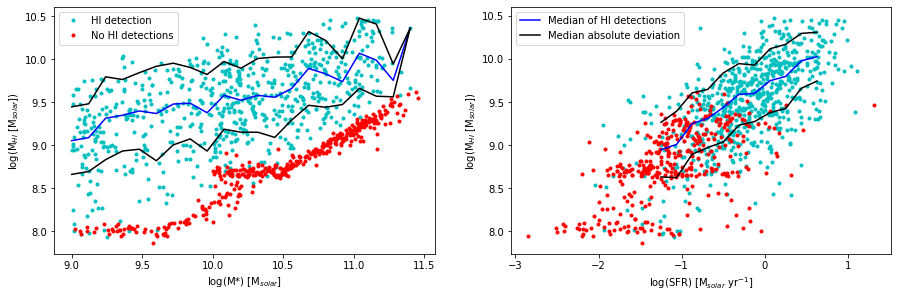

In [7]:
# Global HI mass and HI mass contained in the optical regions with median lines
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.plot(bins[:-2], mHIa[:-2], 'b-')
plt.plot(bins[:-2], pMAD1[:-2], 'k-')
plt.plot(bins[:-2], nMAD1[:-2], 'k-')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.')
plt.plot(bins2[:-2], mHIb[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins2[:-2], pMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins2[:-2], nMAD2[:-2], 'k-')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

In [8]:
# DHI- MHI relation
# For HI detections
lgDHI1 = 0.506*lgMHI1 - 3.293
MHI1 = 10**lgMHI1
DHI1 = 10**lgDHI1
RHI1 = 0.5*DHI1

# For no HI detection
lgDHI2 = 0.506*lgMHI2 - 3.293
MHI2 = 10**lgMHI2
DHI2 = 10**lgDHI2
RHI2 = 0.5*DHI2

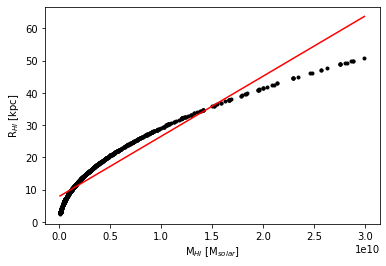

In [9]:
# DHI- MHI relation
lgDHI = 0.506*lgMHI - 3.293
MHI = 10**lgMHI
DHI = 10**lgDHI
RHI = 0.5*DHI

# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(MHI, RHI, 'k.')
plt.ylabel('R$_{HI}$ [kpc]')
plt.xlabel('M$_{HI}$ [M$_{solar}$]')

# Fitting a line to the RHI-MHI relation
x = MHI
p = np.linspace(min(x), max(x), 1000)
y = RHI
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
plt.plot(p, linfun(p, *popt), 'r');

0.7407218209453733


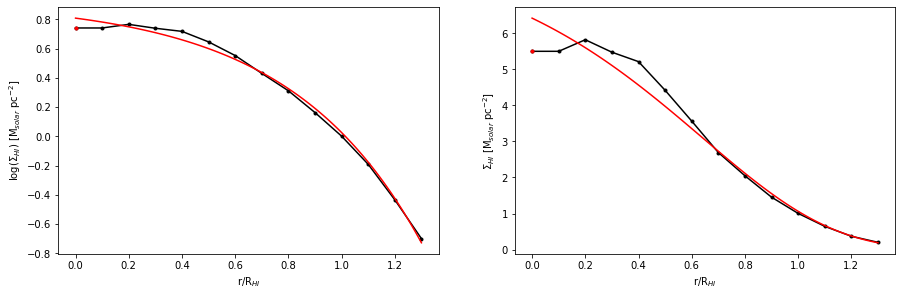

In [10]:
# Need to create a median HI profile of galaxies- (data from Wang et al 2020)
rrHI=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
SigHI=np.array([5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
lgSigHI = np.log10(SigHI)

x1 = np.flip(rrHI)
y1 = lgSigHI
f = interpolate.interp1d(x1, y1, fill_value = "extrapolate")
zpoint = f(max(np.flip(rrHI)))
print(zpoint)

newrrHI = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
newSigHI=np.array([(10**zpoint),5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
newlgSigHI = np.log10(newSigHI)

# Noticable data 'gap' from 0 - 0.1 RHI
# Fitting a curve to the data will allow a different range to be set
# The data ends at 0.1r/RHI, using the fitted curve this can be extrapolated back to r/RHI = 0
x = newrrHI
p = np.linspace(0, max(newrrHI), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the median HI profile using Wang 2020 data
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(newrrHI, newlgSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('log(Σ$_{HI}$) [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.plot(0, zpoint, 'r.');

plt.subplot(222)
plt.plot(newrrHI, newSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, 10**curvefun(p, *popt), 'r-')
plt.plot(0, 10**zpoint, 'r.');

In [11]:
# Converting the petrosian flux in the r band from arcsec to parsec
# Assuming the following cosmology
cosmology = FlatLambdaCDM(H0 = 70, Om0 = 0.3, Tcmb0 = 2.273)
# Converting the data, where .arcsec_per_kpc_proper is the equation of proper distance, using the redshift of the galaxies
arckpc1 = cosmology.arcsec_per_kpc_proper(zSDSS1)
r90kpc = petro90r1/arckpc1
# Normalise r90 by dividing by RHI
r90norma = (r90kpc/RHI1)
print(r90norma[0:11])

[0.41045764 0.47962425 0.401255   0.69175735 0.42232271 0.47379863
 0.34860138 0.31304847 0.39714913 0.22548857 0.26414082] kpc / arcsec


In [12]:
# Using the equations:
# Angular diameter distance of a galaxy at redshift z:
# DA(z) = DL(z)/(1+z)^2
# Definition of angular diameter distance:
# Theta = size(l)/DA(z)
# Combining these to an expression of the size of a galaxy in kpc, will allow the conversion of the petrosian 90 r band data from units of arcsec to parsec
# This then allows for the calculation of r90/RHI and the scaling to find the surface density for each galaxy, using the profile estabilished above
# Function:
def arcpc(z, theta, Dlumin):
  arcrad = ((2*np.pi)/360) * (1/3600)
  return (Dlumin* arcrad * theta) / ((1+z)**2)

r90pc1 = arcpc(zSDSS1, petro90r1, Dlum1)
r90pc2 = arcpc(zSDSS2, petro90r2, Dlum2)

# Normalising the converted r band petrosian flux by dividing by RHI
r90norm1 = (r90pc1*1000) / RHI1
r90norm2 = (r90pc2*1000) / RHI2
print(r90norm1[0:11])

[0.41035736 0.47965283 0.40139577 0.69165092 0.42234525 0.47374361
 0.34869168 0.31324044 0.39724232 0.22558298 0.26414426]


In [13]:
# Conditions for the dataset
# 1) When r90 > 1.3RHI, MHIout = 0, i.e- do not integrate
# 2) When r90 < 1.3RHI, MHIout is found by integrating from r90 --> 1.3 RHI
# Applying these conditions to the data:
bigr901 = np.where(r90norm1 > 1.3)[0]
r90norm1a = np.delete(r90norm1, (bigr901))
bigr902 = np.where(r90norm2 > 1.3)[0]
r90norm2a = np.delete(r90norm2, (bigr902))

# log(Mass(HI)) taking away r90norm1,2 > 1.3RHI
lgMHI1a = np.delete(lgMHI1, (bigr901))
lgMHI2a = np.delete(lgMHI2, (bigr902))

# log(Mstar) and log(SFR) taking away r90norm1,2 > 1.3RHI
lgMstar1a = np.delete(lgMstar1, (bigr901))
lgMstar2a = np.delete(lgMstar2, (bigr902))

lgSFR1a = np.delete(np.log10(SFR_best1), (bigr901))
lgSFR2a = np.delete(np.log10(SFR_best2), (bigr902))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


In [14]:
# Interpolating the r90/RHI data along the surface density profile
lgf = interpolate.interp1d(p, curvefun(p, *popt))
f = interpolate.interp1d(p, 10**curvefun(p, *popt))
# Interpolating HI detections
lginterHISig = lgf(r90norm1a)
interHISig = f(r90norm1a)
# Interpolating no HI detections
lginternHISig = lgf(r90norm2a)
internHISig = f(r90norm2a)
#, fill_value="extrapolate"

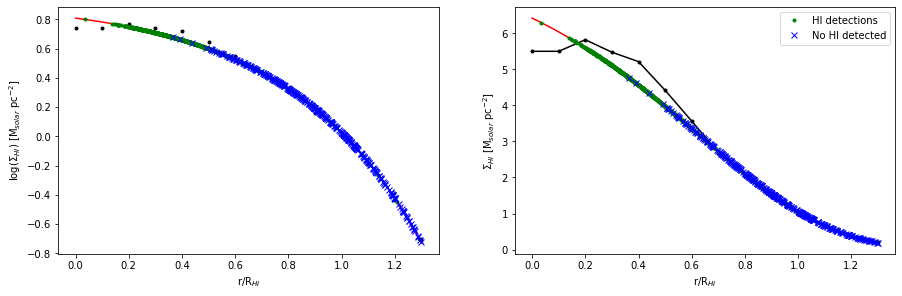

In [15]:
# Plotting the interpolated data
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(newrrHI, newlgSigHI, 'k.')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('log(Σ$_{HI}$) [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, curvefun(p, *popt), 'r-')
# HI detection
plt.plot(r90norm1a, lginterHISig, 'g.')
# no HI detection
plt.plot(r90norm2a, lginternHISig, 'bx')
#plt.plot(0, zpoint, 'r.')

plt.subplot(222)
plt.plot(newrrHI, newSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, 10**curvefun(p, *popt), 'r-')
# HI detection
plt.plot(r90norm1a, interHISig, 'g.', label= 'HI detections')
# no HI detection
plt.plot(r90norm2a, internHISig, 'bx', label= 'No HI detected');
#plt.plot(0, 10**zpoint, 'r.')
plt.legend(loc= 'upper right');

In [16]:
# To find MHI out --> integrate from the r90/RHI value of a given galaxy to the maximum, 1.3
# Integration will be computed via trapezoidal rule integration
# Range arrays for the trapezium rule to calculate over
x_arr1 = r90norm1a
y_arr1 = curvefun(x_arr1, 1,1,1,1)

x_arr2 = r90norm2a
y_arr2 = curvefun(x_arr2, 1,1,1,1)

# Array of zeroes to store the output data
areas1 = np.zeros(len(x_arr1))
mHIout1 = np.zeros(len(x_arr1))

areas2 = np.zeros(len(x_arr2))
mHIout2 = np.zeros(len(x_arr2))

test = np.zeros(len(x_arr1))
test2 = np.zeros(len(x_arr2))

# Pair of for loops to determine the integral of each galaxy from its r90/RHI position to the end of the surface density profile at 1.3R(HI)
for i in range(len(x_arr1) -1):
  dx1 = (x_arr1[684] - x_arr1[i]) / len(x_arr1[i:684])
  areas1[i] = np.trapz(y_arr1[i:684], x_arr1[i:684], dx = dx1)
  mHIout1[i] = areas1[i]
#, x_arr1[i:684]

for i in range(len(x_arr2) -1):
  dx2 = (x_arr2[346] - x_arr2[i]) / len(x_arr2[i:346])
  areas2[i] = np.trapz(y_arr2[i:346], x_arr2[i:346], dx = dx2)
  mHIout2[i] = areas2[i]
#, x_arr2[i:346]

for i in range(len(x_arr1) -1):
  test[i] = (x_arr1[684] - x_arr1[i]) / len(x_arr1[i:684])
for i in range(len(x_arr2) -1):
  test2[i] = (x_arr2[346] - x_arr2[i]) / len(x_arr2[i:346])

# Determining the HI mass per galaxy that is outside the optical r90
# This is the fraction that is outside multiplied by the global HI mass
detHIout = 10**lgMHI1a * mHIout1
ndetHIout = 10**lgMHI2a * mHIout2

# Estimating the HI mass inside the optical r90 radius by using the following:
# Mass(HI, inside) = Mass(HI, global) - Mass(HI, outside)
# This will be repeated for the HI (det) and no HI (ndet) galaxy separately

detHIin = 10**lgMHI1a - detHIout
ndetHIin = 10**lgMHI2a - ndetHIout
lgdetHIin = np.log10(detHIin)
lgndetHIin = np.log10(ndetHIin)

In [22]:
# Finding the running median of the HI detections
# Arrays for the bins
INbins = np.linspace(9, 12, 22)
INbins2 = np.linspace(-1.25, 1, 26)

# Array of zeroes to store the median of each bin
INmHIa = np.zeros(len(INbins))
INmedian1 = np.zeros(len(INbins))
INMAD1 = np.zeros(len(INbins))

INmHIb = np.zeros(len(INbins2))
INmedian2 = np.zeros(len(INbins2))
INMAD2 = np.zeros(len(INbins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(INbins) -1):
  # Median and MAD for HI of galaxies against stellar mass
  INmedian1[i] = np.median(lgdetHIin[np.where((lgMstar1a >= INbins[i]) & (lgMstar1a <= INbins[i+1]))])
  INMAD1[i] = stats.median_absolute_deviation(lgdetHIin[np.where((lgMstar1a >= INbins[i]) & (lgMstar1a <= INbins[i+1]))])
  INmHIa[i] = INmedian1[i]

for i in range (len(INbins2) -1):
  # Median and MAD for HI of galaxies against SFR
  INmedian2[i] = np.median(lgdetHIin[np.where((lgSFR1a >= INbins2[i]) & (lgSFR1a <= INbins2[i+1]))])
  INMAD2[i] = stats.median_absolute_deviation(lgdetHIin[np.where((lgSFR1a >= INbins2[i]) & (lgSFR1a <= INbins2[i+1]))])
  INmHIb[i] = INmedian2[i]

# Working out the upper and lower bounds of the median absolute deviation
INpMAD1 = INmHIa + INMAD1
INnMAD1 = INmHIa - INMAD1
INpMAD2 = INmHIb + INMAD2
INnMAD2 = INmHIb - INMAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


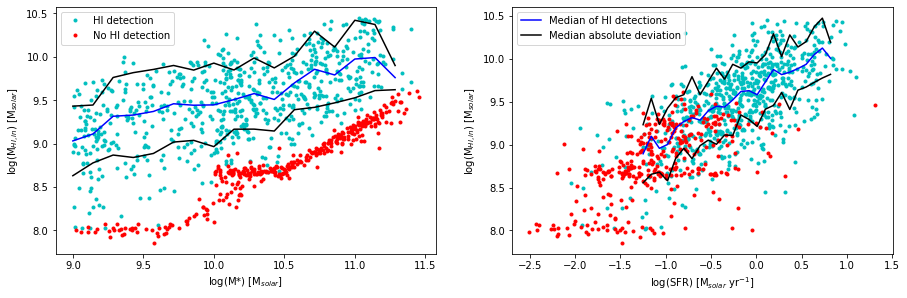

In [23]:
# Plotting the HI mass within the optical radius, against stellar masses and SFR
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(lgMstar1a, lgdetHIin, 'c.', label= 'HI detection')
plt.plot(lgMstar2a, lgndetHIin, 'r.', label= 'No HI detection')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI, in}$) [M$_{solar}$]')
plt.plot(INbins[:-2], INmHIa[:-2], 'b-')
plt.plot(INbins[:-2], INpMAD1[:-2], 'k-')
plt.plot(INbins[:-2], INnMAD1[:-2], 'k-')
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(lgSFR1a, lgdetHIin, 'c.')
plt.plot(lgSFR2a, lgndetHIin, 'r.')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI, in}$) [M$_{solar}$]')
plt.plot(INbins2[:-2], INmHIb[:-2], 'b-', label = 'Median of HI detections')
plt.plot(INbins2[:-2], INpMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(INbins2[:-2], INnMAD2[:-2], 'k-')
plt.legend(loc='upper left');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


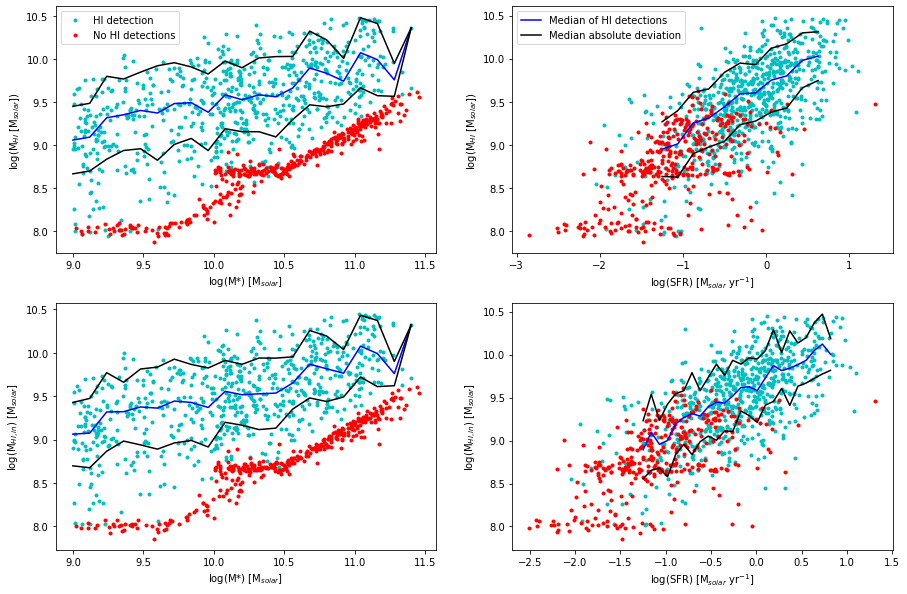

In [20]:
plt.figure(figsize = (15,10))

# Global HI mass and HI mass contained in the optical regions with median lines
plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.plot(bins[:-2], mHIa[:-2], 'b-')
plt.plot(bins[:-2], pMAD1[:-2], 'k-')
plt.plot(bins[:-2], nMAD1[:-2], 'k-')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.')
plt.plot(bins2[:-2], mHIb[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins2[:-2], pMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins2[:-2], nMAD2[:-2], 'k-')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

# Plotting the HI mass within the optical radius, against stellar masses and SFR
plt.subplot(223)
plt.plot(lgMstar1a, lgdetHIin, 'c.')
plt.plot(lgMstar2a, lgndetHIin, 'r.')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI, in}$) [M$_{solar}$]')
plt.plot(INbins[:-2], INmHIa[:-2], 'b-')
plt.plot(INbins[:-2], INpMAD1[:-2], 'k-')
plt.plot(INbins[:-2], INnMAD1[:-2], 'k-');


plt.subplot(224)
plt.plot(lgSFR1a, lgdetHIin, 'c.')
plt.plot(lgSFR2a, lgndetHIin, 'r.')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI, in}$) [M$_{solar}$]')
plt.plot(INbins2[:-2], INmHIb[:-2], 'b-')
plt.plot(INbins2[:-2], INpMAD2[:-2], 'k-')
plt.plot(INbins2[:-2], INnMAD2[:-2], 'k-');